In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, precision_score,
    recall_score, f1_score
)

from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
# === Step 2: Load Dataset ===
df = pd.read_csv("../data/MachineLearningRating_v3_cleaned_task3.csv")

C:\Users\ayish\AppData\Local\Temp\ipykernel_12488\4061434379.py:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/MachineLearningRating_v3_cleaned_task3.csv")


In [3]:
#display first few rows
print(df.head())

   UnderwrittenCoverID  PolicyID     TransactionMonth  IsVATRegistered  \
0               145249     12827  2015-03-01 00:00:00             True   
1               145249     12827  2015-05-01 00:00:00             True   
2               145249     12827  2015-07-01 00:00:00             True   
3               145255     12827  2015-05-01 00:00:00             True   
4               145255     12827  2015-07-01 00:00:00             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  ...                    ExcessSelected CoverCategory  \
0  Current account  ...             Mobility - 

In [4]:
#display dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 50 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      1000098 non-null  object 
 9   AccountType               1000098 non-null  object 
 10  MaritalStatus             1000098 non-null  object 
 11  Gender                    1000098 non-null  object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

In [5]:
# ----------------------------------
# Step 1: Data Preparation
# ----------------------------------

# Handle datetime columns correctly
for col in df.columns:
    if df[col].astype(str).str.contains("00:00:00").any():
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col + '_year'] = df[col].dt.year
        df[col + '_month'] = df[col].dt.month
        df.drop(columns=col, inplace=True)

In [7]:
# Drop columns with >80% missing
threshold = 0.8 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# Impute missing values
df.fillna(df.mean(numeric_only=True), inplace=True)  # numerical
df.fillna(df.mode().iloc[0], inplace=True)             # categorical

In [8]:
# Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Avoid divide-by-zero for Loss Ratio
df = df[(df['TotalPremium'] != 0) & (~df['TotalPremium'].isnull())]
df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']

In [9]:
# ----------------------------------
# Step 2: Claim Severity Prediction (Regression)
# ----------------------------------
print("Running Claim Severity Model...")
df_severity = df[df['TotalClaims'] > 0].copy()
X_severity = df_severity.drop(columns=['TotalClaims', 'TotalPremium'])
y_severity = df_severity['TotalClaims']

X_train, X_test, y_train, y_test = train_test_split(X_severity, y_severity, test_size=0.2, random_state=42)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results (Claim Severity):")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R² Score:", r2_score(y_test, y_pred))

Running Claim Severity Model...

LinearRegression Results (Claim Severity):
RMSE: 23496.508773175927
R² Score: 0.4435893738741745

RandomForest Results (Claim Severity):
RMSE: 4826.710416680338
R² Score: 0.9765203711379119

XGBoost Results (Claim Severity):
RMSE: 6061.63212315184
R² Score: 0.962968790930661


In [10]:
# ----------------------------------
# Step 3: Premium Prediction (Regression)
# ----------------------------------
print("\nRunning Premium Prediction Model...")
X_premium = df.drop(columns=['TotalPremium', 'TotalClaims'])
y_premium = df['TotalPremium']

X_train, X_test, y_train, y_test = train_test_split(X_premium, y_premium, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results (Premium Prediction):")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R² Score:", r2_score(y_test, y_pred))


Running Premium Prediction Model...

LinearRegression Results (Premium Prediction):
RMSE: 49.29138516288
R² Score: 0.9776392456480161

RandomForest Results (Premium Prediction):
RMSE: 60.885820793050364
R² Score: 0.9658825365122612

XGBoost Results (Premium Prediction):
RMSE: 106.64532922309432
R² Score: 0.8953285877387795


In [11]:
# ----------------------------------
# Step 4: Claim Probability Prediction (Classification)
# ----------------------------------
print("\nRunning Claim Probability Model...")
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
X_class = df.drop(columns=['TotalClaims', 'TotalPremium', 'HasClaim'])
y_class = df['HasClaim']

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n{name} Results (Claim Probability):")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))


Running Claim Probability Model...


d:\kaimtenx\week3\insurance-analytics-project\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression Results (Claim Probability):
Accuracy: 0.9956181837290712
Precision: 0.6
Recall: 0.0055248618784530384
F1 Score: 0.010948905109489052

RandomForestClassifier Results (Claim Probability):
Accuracy: 0.9999919154681348
Precision: 1.0
Recall: 0.998158379373849
F1 Score: 0.9990783410138249


d:\kaimtenx\week3\insurance-analytics-project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [13:40:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBClassifier Results (Claim Probability):
Accuracy: 0.9996685341935275
Precision: 0.998015873015873
Recall: 0.9263351749539595
F1 Score: 0.9608404966571156


In [14]:
import pandas as pd

# Convert datetime columns to numeric
for col in X_train.select_dtypes(include='datetime').columns:
    X_train[col] = X_train[col].astype('int64')  # or .view('int64')
    X_test[col] = X_test[col].astype('int64')

# Confirm all categorical columns are encoded
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align train and test sets
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Confirm all numeric types
print(X_train.dtypes.value_counts())  # should only show int64, float64


int64      38
float64     9
int32       2
bool        1
Name: count, dtype: int64


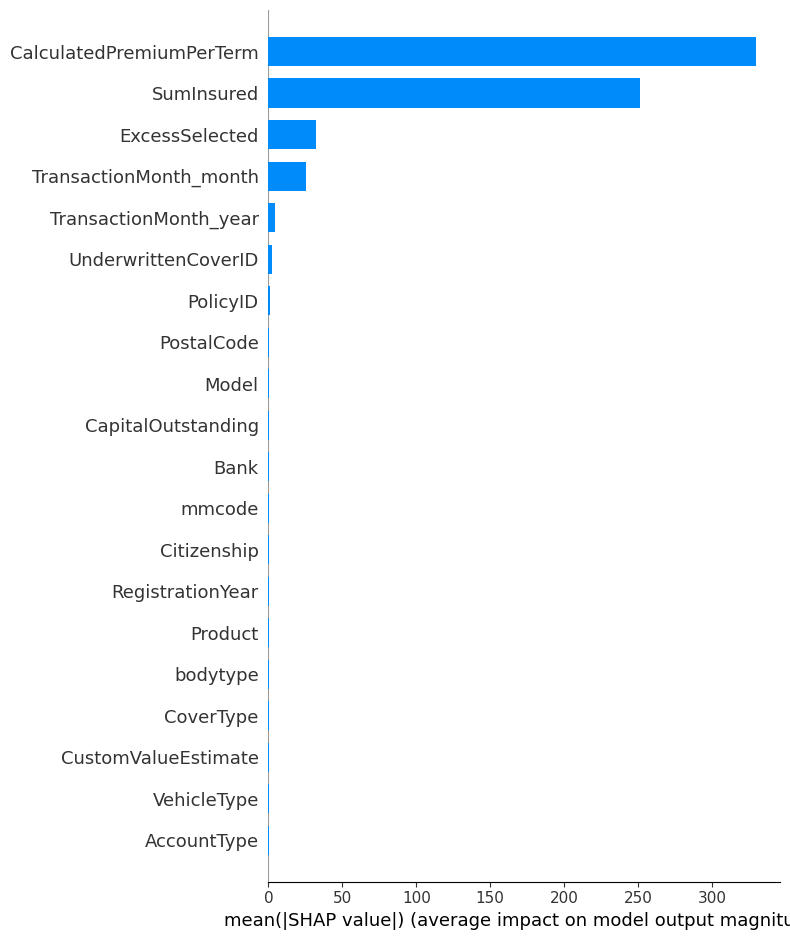

In [16]:
import shap
import matplotlib.pyplot as plt

# Ensure SHAP runs in CPU mode
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Use TreeExplainer for XGBoost models
# If you previously trained: models["XGBoost"] = XGBRegressor().fit(X_train, y_train)
xgb_model = models["XGBoost"]

# Sample 100 rows from X_test to reduce SHAP computation load
X_sample = X_test.sample(n=100, random_state=42)

# Initialize SHAP TreeExplainer
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_sample)

# Plot SHAP summary bar chart
shap.summary_plot(shap_values, X_sample, plot_type="bar")


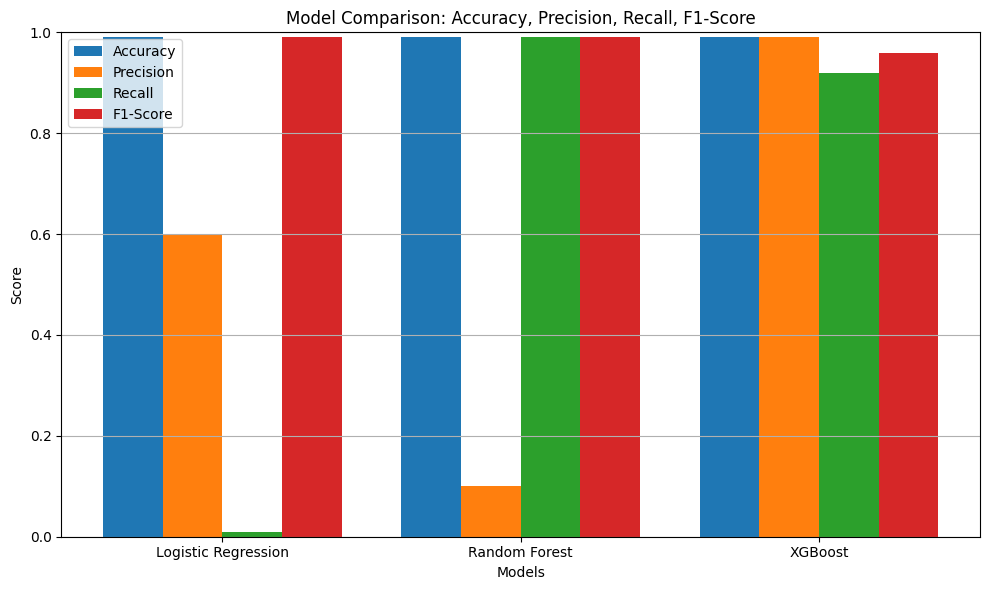

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Example results dictionary (replace with your actual results)
results = {
    "Logistic Regression": {
        "Accuracy": 0.99,
        "Precision": 0.6,
        "Recall": 0.01,
        "F1-Score": 0.99
    },
    "Random Forest": {
        "Accuracy": 0.99,
        "Precision": 0.1,
        "Recall": 0.99,
        "F1-Score": 0.99
    },
    "XGBoost": {
        "Accuracy": 0.99,
        "Precision": 0.99,
        "Recall": 0.92,
        "F1-Score": 0.96
    }
}

# Extract metric names and model names
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
models = list(results.keys())

# Extract values for each metric
metric_values = {metric: [results[model][metric] for model in models] for metric in metrics}

# Plotting
x = np.arange(len(models))  # label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each metric
for idx, metric in enumerate(metrics):
    ax.bar(x + idx * width, metric_values[metric], width, label=metric)

# Formatting
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Accuracy, Precision, Recall, F1-Score')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models)
ax.legend()
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
